# How to simulate multi-qubit circuits in quantum computing
**Evaluate the performance of multi-qubit circuits with and without noise**

Boulder Opal enables you to simulate the evolution of isolated quantum systems  and systems that are interacting with their environment (see the [Simulate open systems dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-open-system-dynamics) user guide). 

In this notebook, we will show how the same simulation features can be used to simulate a multi-qubit quantum circuit as encountered specifically in quantum computing.  Our focus is on adding functionality which faithfully represents the dynamics of laboratory quantum computers subject to bounded-strength controls and real noise sources.

## Summary workflow

In general, the operations constituting a quantum circuit must be translated from logical operators to the drive controls typically employed in the dynamic simulations supported in Boulder Opal. 

### 1. Link logic gates to control pulses
We start with the definition of a universal gateset. While there are many approaches to compilation, we assume a need for five unique pulses in order to realize a universal gateset: three pulses that rotate a qubit by $\pi/2$ radians along the $X$, the $Y$ and the $Z$-axis, a pulse that rotates a qubit by $\pi$ radians along the $Z$-axis, and a pulse that rotates a two-qubit channel by $-\pi/2$ radians. 

We will use the notation $Y_\theta = Y(\theta) = \exp (-i\frac{\theta}{2}\sigma^y)$ to denote a rotation of angle $\theta$ along the Y-axis (and the same notation for rotations along the X and the Z axis).

Ignoring global phases, the Hadamard gate can be constructed with two rotations
$$
H = Y_{\pi/2} Z_{\pi}  ,
$$
and the CNOT gate can be obtained by combining two single qubit rotations and one two-qubit rotation
$$
\rm{CNOT}^{ij} = Z^i_{\pi/2} X^j_{\pi/2} \rm{XZ}^{ji}_{-\pi/2}  .
$$

We also assume access to [_virtual_-$Z$ rotations](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.022330) which do not change populations in the computational basis, although you may choose to add an alternative approach to realizing such a rotation. 

In order to realize these gates we require only two complex drives:

- $\Omega(t)_i$ is a drive for a single-qubit $i$
- $\Gamma(t)_{ij}$ is a drive which induces a coupling between qubits $(i,j)$ as used in an entangling gate.

We will also assume that the controls $\Omega_i(t)$ can be selected between the values $[-\Omega_{\rm max}, \Omega_{\rm max}]$ and controls $\Gamma_{ij}(t)$ can be selected between $[-\Gamma_{\rm max}, \Gamma_{\rm max}]$.

### 2. Create a pulse schedule from a circuit
You can now combine the pulses and virtual $Z$-rotations together to generate a _schedule_, a series of pulses applied to the controls, that represent the circuit at the level of Hamiltonian manipulation. To implement any circuit, we will drive the system by appropriately setting the values of $\Omega_i$ and $\Gamma_{ij}$, and add periods of zero-value when a gate is not active. 

We will refer to each of these variables as _channels_, such that $\Omega_0$ is called Channel $0$, $\Gamma_{01}$ is called Channel $01$, etc. Under this convention, for example, Channel $10$ allows us to apply the CNOT gate between the first and the second qubit using the CNOT formula listed above.

You can specify the schedule manually (as we do in the example below), or automatically using a software scheduler such as the [qiskit.compiler.schedule](https://qiskit.org/documentation/apidoc/compiler.html#qiskit.compiler.schedule) provided by Qiskit.

For more general information  about quantum compilation and scheduling, see for example [Shi et al.](https://arxiv.org/abs/1902.01474).

### 3. Simulate dynamic evolution under a pulse schedule

To simulate the dynamics of this multi-qubit quantum circuit with Boulder Opal, we start by setting up a graph object as described in the [How to represent quantum systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) user guide. After setting up the piecewise-constant (PWC) Hamiltonian of the system, we create a simulation node using the  `graph.time_evolution_operators_pwc` operation and request samples at `sample_times` points. 

We can also use `graph.density_matrix_evolution_pwc` to simulate an open system evolution as outlined in the [How to simulate open system dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-open-system-dynamics) user guide.

### 4. Include time-varying noise 
We can add a random noise process sampled from a power spectral density to a simulation as described in the [How to simulate quantum dynamics subject to noise with graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-subject-to-noise-with-graphs) user guide.  Since the noise process is random, we need to run many simulations of the circuit with the noise to get a correct estimate of the system evolution. In each simulation run, we sample the power spectrum of the noise three times to obtain different time-domain realizations of the noise variable $\eta(t)$ and then use these trajectories to construct a noisy Hamiltonian. This noisy Hamiltonian is added to the system Hamiltonian and we simulate the total Hamiltonian to obtain a noisy final state. 

### 5. Execute graph-based simulation 
Execute the graph-based simulation using standard procedures.  After running many simulations, we average out the final states to obtain the density matrix representing the noisy evolution. Instead of running each different realization of the noisy system one by one, we can use the batching feature to run multiple simulations with just one call to the `boulderopal.execute_graph` function. 

After the simulation is successfully completed, we obtain the trajectories of the system in the variable `final_states`. The first dimension of the `final_states` is of length `batch_count`, the second dimension accounts for the time points sampled from the evolution, and the last two dimensions contain the state vector at each of the time point. 

See the `graph.pwc_signal` operation to learn more about batches in the Boulder Opal simulation engine.

## Example: Simulating the creation of a 3-qubit GHZ state
Consider a three qubit system which has a single qubit drive on each qubit and a two-qubit cross-resonance drive between each consecutive pair (1-2 and 2-3) of qubits. The Hamiltonian for the single qubit drive on qubit $i$ is given by
$$
H^{\rm{S}}_{i}(t) = \frac{1}{2} \Omega_{i}(t) \sigma^{-}_{i} + \frac{1}{2} \Omega_{i}^{*}(t)\sigma^{+}_{i}
$$
and the Hamiltonian of the two-qubit cross-resonance drive between qubit $i$ and $j$ is given by
$$
H^{\rm{CR}}_{ij}(t) = \frac{1}{2} \left( \Gamma_{ij}(t) \sigma^{-}_{i} + \Gamma_{ij}^{*}(t)\sigma^{+}_{i} \right)  \otimes \sigma^{z}_j  ,
$$
where $\sigma^x$, $\sigma^y$ and $\sigma^z$ are the Pauli matrices, $\sigma^{\pm} = (\sigma^x \mp i \sigma^y)/2$ are the Pauli ladder operators, and $\Omega_i$ and $\Gamma_{ij}$ are complex Rabi rates that control the single qubit evolution and the two-qubit evolution respectively. The total system Hamiltonian is then
$$
H^{\rm{total}}(t) = \sum_{i=1}^3 H^{\rm{S}}_{i}(t) + \sum_{i=1,2} H^{\rm{CR}}_{i,i+1}(t) +  H^{\rm{CR}}_{i+1,i}(t)  .
$$

This cross-resonance Hamiltonian model approximates the behavior of many commercial quantum computing devices as described in a review by [Krantz et al.](https://doi.org/10.1063/1.5089550).


### Noise-free simulation of GHZ-state generation
We want to use this Hamiltonian to implement a circuit that prepares the Greenberger–Horne–Zeilinger (GHZ) state
$$
\left| \rm{GHZ} \right> = \frac{\left( \left| 000 \right> + \left| 111 \right> \right)}{\sqrt{2}}  .
$$
We can use the standard three-qubit GHZ circuit —which contains a Hadamard gate on the first qubit followed by two CNOT gates between the first and the second qubit, and the second and the third qubit— to prepare this state.

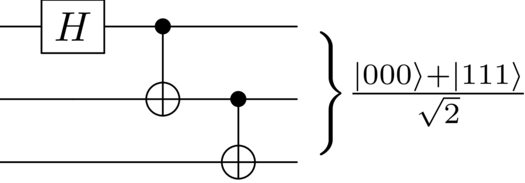

Let us generate these different pulses using the [CORPSE](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_corpse_control) pulse provided by the Q-CTRL Open Controls package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define control parameters.
omega_max = 2 * np.pi * 1e6  # Hz
gamma_max = np.pi * 1e6  # Hz

# Get predefined X90, Y90 and CR pulses,
# new_corpse_control creates a pulse with three segments.
dt = 3
X90_pulse = oc.new_corpse_control(
    rabi_rotation=np.pi / 2, maximum_rabi_rate=omega_max, azimuthal_angle=0, name="X90"
)
Y90_pulse = oc.new_corpse_control(
    rabi_rotation=np.pi / 2,
    maximum_rabi_rate=omega_max,
    azimuthal_angle=np.pi / 2,
    name="Y90",
)
CR90m_pulse = oc.new_corpse_control(
    rabi_rotation=np.pi / 2,
    maximum_rabi_rate=gamma_max,
    azimuthal_angle=np.pi,
    name="CR90m",
)

# Get the amplitude of these pulses.
X90_amplitude = X90_pulse.amplitude_x + 1j * X90_pulse.amplitude_y
Y90_amplitude = Y90_pulse.amplitude_x + 1j * Y90_pulse.amplitude_y
CR90m_amplitude = CR90m_pulse.amplitude_x + 1j * CR90m_pulse.amplitude_y

In [3]:
# Create signals on each of the five channels to constitute a pulse schedule.

# Time segments
durations = np.concatenate(
    [
        pulse.durations
        for pulse in [Y90_pulse, CR90m_pulse, X90_pulse, CR90m_pulse, X90_pulse]
    ]
)
circuit_segment_count = len(durations)
t = 0

# Declare channels
channel_0 = np.zeros(circuit_segment_count, dtype=complex)  # Acts on qubit 0
channel_1 = np.zeros(circuit_segment_count, dtype=complex)  # Acts on qubit 1
channel_2 = np.zeros(circuit_segment_count, dtype=complex)  # Acts on qubit 2
channel_10 = np.zeros(circuit_segment_count, dtype=complex)  # Acts on qubits 1-0
channel_21 = np.zeros(circuit_segment_count, dtype=complex)  # Acts on qubits 2-1

# Phases keep track of the virtual Z-rotations.
phases = np.zeros((3,), dtype=float)

# Apply the Hadamard gate on qubit 0.
phases[0] += -np.pi
channel_0[t : t + dt] = Y90_amplitude * np.exp(1j * phases[0])
t += dt

# Apply the CX gate between qubit 0-1.
channel_10[t : t + dt] = CR90m_amplitude * np.exp(1j * phases[1])
t += dt
channel_1[t : t + dt] = X90_amplitude * np.exp(1j * phases[1])
t += dt
phases[0] += -np.pi / 2

# Apply the CX gate between qubit 1-2.
channel_21[t : t + dt] = CR90m_amplitude * np.exp(1j * phases[2])
t += dt
channel_2[t : t + dt] = X90_amplitude * np.exp(1j * phases[2])
t += dt
phases[1] += -np.pi / 2

Let us visualize the schedule as a series of pulses on the five different channels involved in this circuit. We notice that each channel has a series of three-segment pulses which shows the application of various pulses to achieve different gates required to prepare the GHZ state. The total GHZ Hamiltonian will therefore be defined over 15 time segments. 

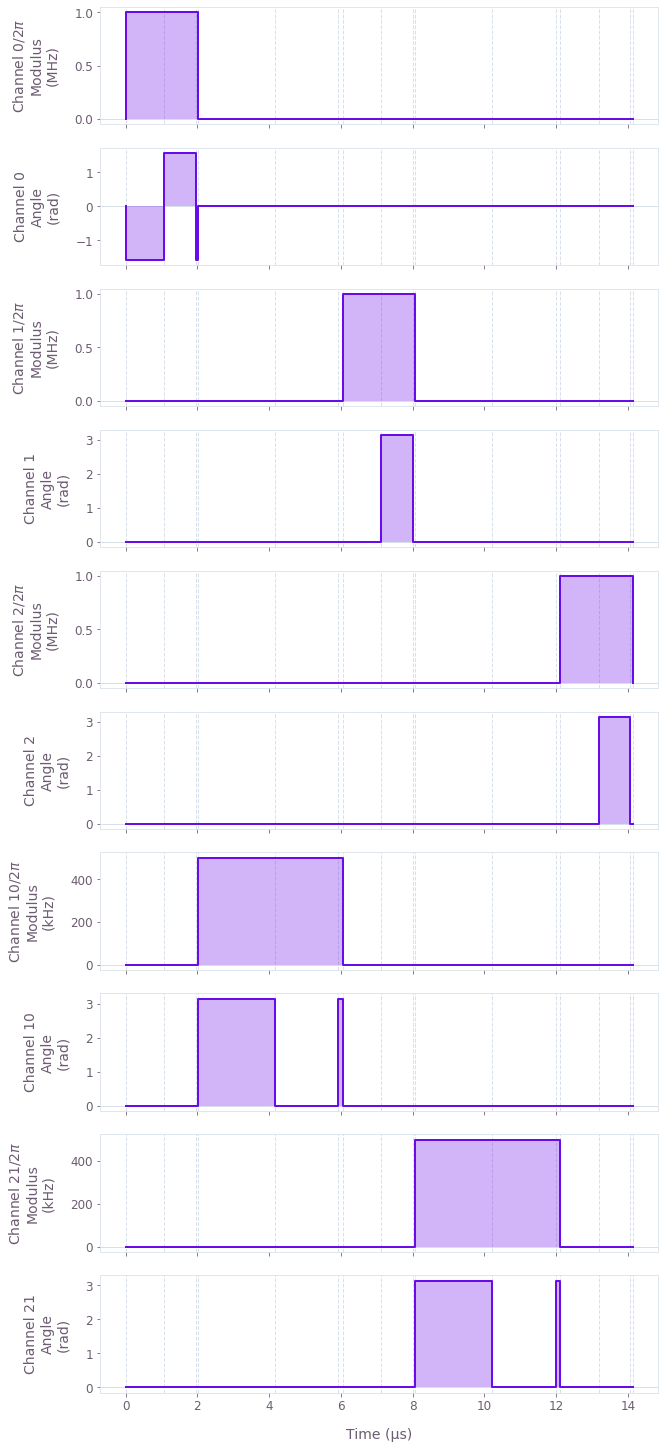

In [4]:
qv.plot_controls(
    {
        key: {"durations": durations, "values": channel}
        for key, channel in zip(
            ["Channel 0", "Channel 1", "Channel 2", "Channel 10", "Channel 21"],
            [channel_0, channel_1, channel_2, channel_10, channel_21],
        )
    }
)

In [5]:
sample_times = np.linspace(0, np.sum(durations), 200)

# Create graph to simulate the circuit linked to the channel definitions above.
graph = bo.Graph()

# Define the initial state.
initial_state = graph.fock_state(2**3, 0)

# Define the controls on the five channels.
signal_0 = graph.pwc(durations=durations, values=channel_0)
signal_1 = graph.pwc(durations=durations, values=channel_1)
signal_2 = graph.pwc(durations=durations, values=channel_2)
signal_10 = graph.pwc(durations=durations, values=channel_10)
signal_21 = graph.pwc(durations=durations, values=channel_21)

# Next, define the various local Hamiltonian terms.
term_0 = signal_0 * graph.pauli_kronecker_product([("M", 0)], 3)
term_1 = signal_1 * graph.pauli_kronecker_product([("M", 1)], 3)
term_2 = signal_2 * graph.pauli_kronecker_product([("M", 2)], 3)
term_10 = signal_10 * graph.pauli_kronecker_product([("Z", 0), ("M", 1)], 3)
term_21 = signal_21 * graph.pauli_kronecker_product([("Z", 1), ("M", 2)], 3)

# Combine the terms to obtain the system Hamiltonian.
term_sum = term_0 + term_1 + term_2 + term_10 + term_21
system_hamiltonian = graph.hermitian_part(term_sum)

# Compute the unitaries.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=system_hamiltonian, sample_times=sample_times
)

# Evolve the initial state with the unitaries.
states = unitaries @ initial_state[:, None]
states.name = "states"

# Run simulation.
results = bo.execute_graph(graph=graph, output_node_names="states")

Your task (action_id="1829141") has completed.


Let us visualize the trajectory of the system as gates are applied to the initial state. We see that the entire population starts in the ground state and the population of the ground state $|000\rangle$ and the highest excited state $|111\rangle$ equalizes as expected towards the end of the evolution.

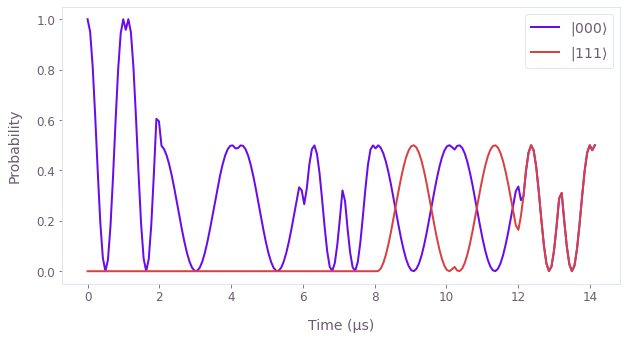

In [6]:
states = results["output"]["states"]["value"]
population = np.squeeze(np.abs(states) ** 2)

qv.plot_population_dynamics(
    sample_times,
    {r"$|000\rangle$": population[:, 0], r"$|111\rangle$": population[:, -1]},
)

### Noisy simulation in the presence of $1/f$ dephasing

Building on this example, suppose there is also a dephasing noise on the single qubit channel:
$$
H^{\rm{S}}_{i}(t) = \frac{1}{2} \Omega_{i}(t) \sigma^{-}_{i} + \frac{1}{2} \Omega_{i}^{*}(t)\sigma^{+}_{i} + \frac{\eta(t)}{2} \sigma^z_i  ,
$$
where $\eta(t)$ is a random variable with a power spectrum that can be described by the pink ($1/f$) noise model shown below.

Here, we will generate batches of noise trajectories using the `graph.random.colored_noise_stf_signal` node. This node creates a batch of continuous noise trajectories from the power density of the pink noise which we then discretize to $50$ equally spaced points between the start and the end of the circuit evolution. From these batches of noise, we will create a batch of noise Hamiltonians where each Hamiltonian of the batch represents a different realization of the noise variable.

We will then add the GHZ Hamiltonian to the batch of noise Hamiltonians to create a batch of total Hamiltonians. The noise Hamiltonians were sampled on $50$ time points between the start and end of the circuit whereas the GHZ Hamiltonian has been defined over $15$ time segments. Boulder Opal automatically reconciles differing time segmentation while summing over Hamiltonian terms. 

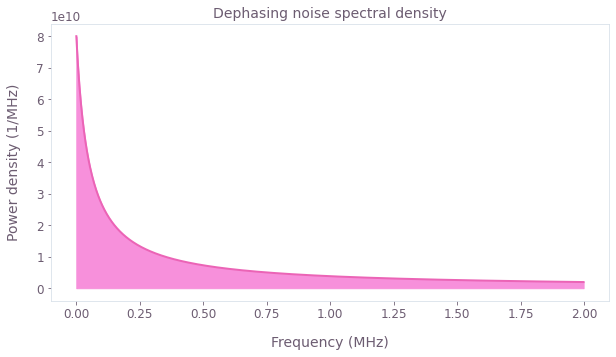

In [7]:
def pink_spectrum(frequencies, frequency_cutoff):
    return 1 / (frequencies + frequency_cutoff)


frequency_step = 2 * 1e3
frequencies = np.arange(0, 2 * 1e6, frequency_step)

power_densities = 4e9 * pink_spectrum(
    frequencies=frequencies, frequency_cutoff=0.05 * 1e6
)

plt.plot(frequencies / 1e6, power_densities * 1e6, color="#EB64B6")
plt.fill_between(frequencies / 1e6, 0, power_densities * 1e6, color="#F790DB")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.title("Dephasing noise spectral density")
plt.show()

In [8]:
# Run these many simulations with different noise trajectories.
simulation_count = 50

# Create a graph for the GHZ circuit with noise trajectories.
graph = bo.Graph()

# Define the initial state.
initial_state = graph.fock_state(2**3, 0)

# Define the controls on the five channels.
signal_0 = graph.pwc(durations=durations, values=channel_0)
signal_1 = graph.pwc(durations=durations, values=channel_1)
signal_2 = graph.pwc(durations=durations, values=channel_2)
signal_10 = graph.pwc(durations=durations, values=channel_10)
signal_21 = graph.pwc(durations=durations, values=channel_21)

# System Hamiltonian.
term_0 = signal_0 * graph.pauli_kronecker_product([("M", 0)], 3)
term_1 = signal_1 * graph.pauli_kronecker_product([("M", 1)], 3)
term_2 = signal_2 * graph.pauli_kronecker_product([("M", 2)], 3)
term_10 = signal_10 * graph.pauli_kronecker_product([("Z", 0), ("M", 1)], 3)
term_21 = signal_21 * graph.pauli_kronecker_product([("Z", 1), ("M", 2)], 3)

system_hamiltonian = graph.hermitian_part(term_0 + term_1 + term_2 + term_10 + term_21)

# Noise Hamiltonian. Generate random noise trajectories for each of the three channels.
noise_channel = []
for _ in range(3):
    noise_stf = graph.random.colored_noise_stf_signal(
        power_spectral_density=power_densities,
        frequency_step=frequency_step,
        batch_shape=(simulation_count,),
    )
    noise_pwc = graph.discretize_stf(
        stf=noise_stf, duration=np.sum(durations), segment_count=50
    )
    noise_channel.append(noise_pwc)

noise_hamiltonian = (
    noise_channel[0] * graph.pauli_kronecker_product([("Z", 0)], 3)
    + noise_channel[1] * graph.pauli_kronecker_product([("Z", 1)], 3)
    + noise_channel[2] * graph.pauli_kronecker_product([("Z", 2)], 3)
)

# Combine the system and the noise Hamiltonian to get the total Hamiltonian.
# We can automatically combine a batched and a non-batched term.
hamiltonian = system_hamiltonian + noise_hamiltonian

# Compute the unitaries.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)

# Use the unitary to evolve the initial state.
states = unitaries @ initial_state[:, None]

# Get the density matrix, ρ = |ψ><ψ|
density_matrices = graph.outer_product(
    states[..., 0], states[..., 0], name="density_matrices"
)

# Run simulation.
results = bo.execute_graph(graph=graph, output_node_names="density_matrices")

density_matrices = results["output"]["density_matrices"]["value"]

Your task (action_id="1829142") is queued.
Your task (action_id="1829142") has started.
Your task (action_id="1829142") has completed.




We can average out these trajectories to obtain the approximate density matrix of the system and plot the population in the $|000\rangle$ and the $|111\rangle$ states.

In [9]:
# Average out the density matrices and get the populations.
noise_population = np.real_if_close(
    np.diagonal(np.average(density_matrices, axis=0), axis1=-1, axis2=-2)
)

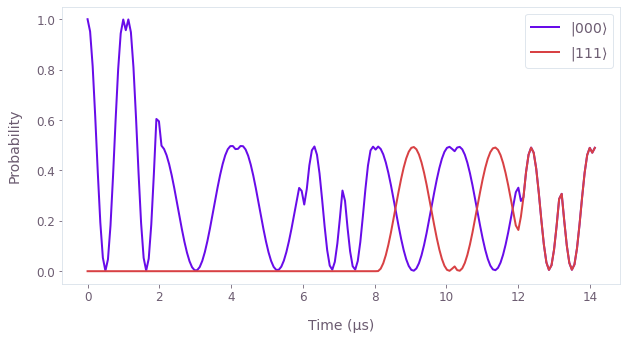

In [10]:
qv.plot_population_dynamics(
    sample_times,
    {
        r"$|000\rangle$": noise_population[:, 0],
        r"$|111\rangle$": noise_population[:, -1],
    },
)

This evolution looks very similar to the noiseless case. The impact of the noise is visible in the difference between the ideal population and the population under noisy evolution. The ideal states lose about $2\%$ of population each.

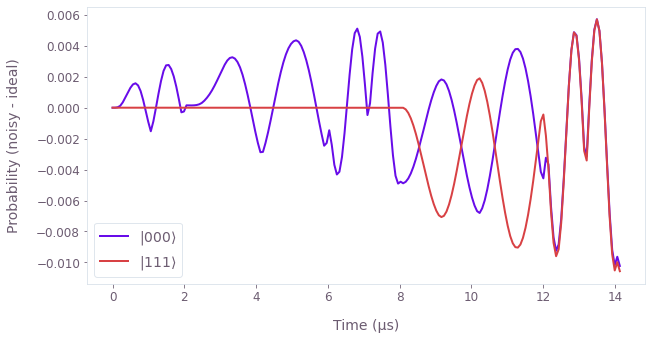

In [11]:
population_difference = noise_population - population
plt.plot(sample_times * 1e6, population_difference[:, [0, -1]])
plt.xlabel("Time (µs)")
plt.ylabel("Probability (noisy - ideal)")
plt.legend([r"$|000\rangle$", r"$|111\rangle$"])
plt.show()

### Summary

We have shown how Boulder Opal can simulate quantum dynamics of a multi-qubit circuit with and without the presence of noise. While we have considered the cross-resonance Hamiltonian model here, the basic principles remain the same for any kind of Hamiltonian model. 